$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

This section is a guide in implementing QITE to obtain the ground state of $\hat{H} = \hat{Z}$. We start from the initial state $\ket{+}$ and wish to propagate the state using a step size of $\Delta\tau = 0.1$ until $\beta = 2.5$. Let us begin by measuring the initial energy of this state.

In [46]:
import numpy as np
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs
from pyquil import Program, get_qc

n = 25
shots = 5000
E = np.zeros([n+1],dtype=complex)
alist = []
def ansatz(p):
    # 1(a). Construct the ansatz for the initial state
    # act Hadamard gate on qubit 0
    p += H(0)
#     print(p)

def measure(p,ro,idx):
    # We define measure as follow: We pass it an index idx that indicates which pauli expectation we want
    # idx = 0, measure "I"
    # idx = 1, measure "X"
    # idx = 2, measure "Y"
    # idx = 3, measure "Z"
    
    if idx == 0:
        return 1
    elif idx == 1:
        qc = get_qc('1q-qvm')
        p += H(0)
        p += MEASURE(0,ro[0])
        exe = qc.compile(p)
        res = qc.run(exe)
        probs = estimate_bitstring_probs(res)
        return probs[0] - probs[1]

    elif idx == 2:
        qc = get_qc('1q-qvm')
        p += RX(np.pi/2,0)
        p += MEASURE(0,ro[0])
        exe = qc.compile(p)
        res = qc.run(exe)
        probs = estimate_bitstring_probs(res)
        return probs[0] - probs[1]
    elif idx == 3:
        qc = get_qc('1q-qvm')
        p += MEASURE(0,ro[0])
        exe = qc.compile(p)
        res = qc.run(exe)
        probs = estimate_bitstring_probs(res)
        return probs[0] - probs[1]

def measure_energy(nn,alist,shots):
    p = Program()
    p.wrap_in_numshots_loop(shots)
    # declare a 1 bit memory space ro (read-out) for measurement
    ro = p.declare('ro','BIT',1)
    ansatz(p)
    Energy = measure(p,ro,3)
    return Energy

E[0] = measure_energy(0,alist,shots)
print('Initial energy is: ',E[0])

Initial energy is:  (0.0036000000000000476+0j)


Now we try to implement the QITE protocol. It will be good to have a big picture of what should be done. We step through imaginary time and at each time step, we should first measure the expectation values of the pauli matrices $\sigma$. This is indicated in the first two lines of the for loop. Using the relevant expectation values, we obtain the coefficients $a[m]$ in equation (2.5) of Lecture 12 using the update rule in equation (2.9-2.11). We store it in a list and use this to propagate our state. Note we have to always reconstruct our state for each new measurements we make. Finally, we measure the current energy values. Let us construct the required functions starting with **get_expectation**

In [ ]:
'''
for i in range(1,n+1):
    sigma_expectation = np.zeros([4],dtype=complex)
    sigma_expectation = get_expectation(i,xlist,shots)
    update_alist(sigma_expectation,alist,db,shots)
    E[i] = measure_energy(i,alist,shots)
'''

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

We make use of the **measure** function we constructed earlier. The key here is to propagate our state using the coefficients in alist. We do this using the **propagate** function. In propagate **propagate**, we loop through the different values store in alist to construct the states. alist is stored as a list of lists and the indices are a[timestep][gate]. The indices of gate are as follows: 
<br>
<br>
1 stores a[x]: $e^{-ia[x]\Delta\tau\hat{X}}$
<br>
2 stores a[y]: $e^{-ia[y]\Delta\tau\hat{Y}}$
<br>
3 stores a[z]: $e^{-ia[z]\Delta\tau\hat{Z}}$
<br>
<br>
The 0 index stores the coefficient for the identity matrix $\hat{I}$, which is a global phase that we can ignore.

In [19]:
def get_expectation(i,alist,shots):
    sigma_expectation = np.zeros([4],dtype=complex)
    for j in range(4):
        p = Program()
        p.wrap_in_numshots_loop(shots)
        ro = p.declare('ro','BIT',1)
        ansatz(p)
        propagate(p,alist,i-1)
        sigma_expectation[j] = measure(p,ro,j)
    return sigma_expectation

def propagate(p,alist,i):
    if i == 0:
        None
    else:
        for t in range(i):
            for gate in range(1,4):
                angle = np.real(alist[t][gate])
                if gate == 1:
                    p += RX(angle,0)
                
                # 2(a) Fill in the missing gates here
                elif gate == 2:
                    p += RY(angle,0)
                elif gate == 3:
                    p += RZ(angle,0)
                else:
                    raise ValueError

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

We now want to obtain the coefficients a[m] at the current time step and append to alist. To do this, we need to construct the matrix $S_{ij} = \bra{\psi}\sigma_{i}\sigma_{j}\ket{\psi}$ and the vector $b_{i}$. Well, our earlier functions allow us to measure the expectation values of the different pauli matrices. How do we obtain $S_{ij}$ from a list of $\bra{\psi}\sigma\ket{\psi}$? We can exploit the fact that up to some coefficients, $\sigma_{i}\sigma_{j} = c_{ij}\sigma_{ij}$. For example, $\sigma_{x}\sigma_{y} = i\sigma_{z}$. We will need a matrix to keep track of what pauli matrix and coefficient we get for $\sigma_{i}\sigma_{j}$. I constructed these and stored it in the matrices **index** and **coefficient** below.


In [22]:
index = np.zeros([4,4],dtype=int)
index[0,0] = 0
index[0,1] = 1
index[0,2] = 2
index[0,3] = 3
index[1,0] = 1
index[1,1] = 0
index[1,2] = 3
index[1,3] = 2
index[2,0] = 2
index[2,1] = 3
index[2,2] = 0
index[2,3] = 1
index[3,0] = 3
index[3,1] = 2
index[3,2] = 1
index[3,3] = 0

coefficient = np.zeros([4,4],dtype=complex)
coefficient[0,0] = 1
coefficient[0,1] = 1
coefficient[0,2] = 1
coefficient[0,3] = 1
coefficient[1,0] = 1
coefficient[1,1] = 1
coefficient[1,2] = 1j
coefficient[1,3] = -1j
coefficient[2,0] = 1
coefficient[2,1] = -1j
coefficient[2,2] = 1
coefficient[2,3] = 1j
coefficient[3,0] = 1
coefficient[3,1] = 1j
coefficient[3,2] = -1j
coefficient[3,3] = 1

print(index)
print(coefficient)

[[0 1 2 3]
 [1 0 3 2]
 [2 3 0 1]
 [3 2 1 0]]
[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  0.+1.j -0.-1.j]
 [ 1.+0.j -0.-1.j  1.+0.j  0.+1.j]
 [ 1.+0.j  0.+1.j -0.-1.j  1.+0.j]]


$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

3. Using this, we can construct the S matrix and b vector. I did it for you in the code segment below. What I want is for you to use these, and the function np.linalg.std to solve for x in equation 2.9. Because the rotation gate is defined as $e^{-i\theta/2\sigma}$, you have to multiply 2 to the x you obtained before storing them in alist (_5 marks_).

In [23]:
def update_alist(sigma_expectation,alist,db,shots):

    # Obtain S matrix
    S = np.zeros([4,4],dtype=complex)
    for i in range(4):
        for j in range(4):
            S[i,j] = sigma_expectation[index[i,j]]*coefficient[i,j]

    # Obtain b vector
    b = np.zeros([4],dtype=complex)
    c = 1
    wt = 1;
    hm = 3;
    c -= 2*db*wt*sigma_expectation[hm]
    c = np.sqrt(c)
    for i in range(4):
        b[i] += (sigma_expectation[i]/c-sigma_expectation[i])/(db)
        b[i] -= wt*coefficient[i,hm]*sigma_expectation[index[i,hm]]/c
        b[i] = -1j*b[i] + 1j*np.conj(b[i])

    # 3(a) Solve for x using np.linalg.lstsq and append your results to alist. Remember to multiply by 2.
    x = np.linalg.lstsq(S+np.transpose(S),-b,rcond=-1)[0]
    alist.append([])
    for i in range(len (x)):
        alist[-1].append(x[i]*2)

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

4. The final thing to do is to modify **measure_energy** to make sure we measure the energy of the propagated states (_2marks_).

In [24]:
def measure_energy(nn,alist,shots):
    p = Program()
    p.wrap_in_numshots_loop(shots)
    ro = p.declare('ro','BIT',1)
    ansatz(p)
    
    # 4(a) Make sure we get the proper state before measuring the energy
    propagate(p,alist,nn)
    Energy = measure(p,ro,3)
    return Energy

5. Now plot how the energy varies with imaginary time (_3 mark_).

/home/abao/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


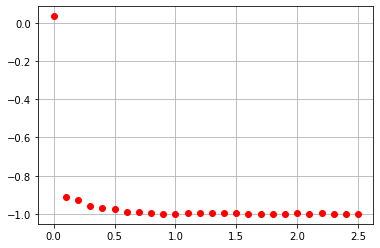

In [8]:
db = 0.1
for i in range(1,n+1):
    sigma_expectation = np.zeros([4],dtype=complex)
    sigma_expectation = get_expectation(i,alist,shots)
    update_alist(sigma_expectation,alist,db,shots)
    E[i] = measure_energy(i,alist,shots)

import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(np.arange(0,n+1)*db,E,'ro')
plt.grid()
plt.show()

6. Modify the ansatz to start from $\ket{0}$, and plot the energy against imaginary time. Explain your results (_2 marks_).